**모델을 생성하고 학습**

In [1]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = pd.read_csv("../pytorch/data/SBUX.csv")
print(data.dtypes)

data["Date"] = pd.to_datetime(data["Date"])
data.set_index("Date", inplace=True)
data["Volume"] = data["Volume"].astype(float)

x = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(x)
print(y)

ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[:200, :]
x_test = x_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", x_train.shape, y_train.shape)
print("Training Shape", x_test.shape, y_test.shape)

x_train_tensors = Variable(torch.Tensor(x_train))
x_test_tensors = Variable(torch.Tensor(x_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

x_train_tensors_f = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], 1, x_test.shape[1]))

print("Training Shape", x_train_tensors_f.shape, y_train_tensors.shape)
print("Training Shape", x_test_tensors_f.shape, y_test_tensors.shape)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002

**모델의 네트워크**

In [2]:
class biLSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(biLSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size))
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = self.relu(out)
        return out

**모델 학습**

In [3]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = biLSTM(num_classes, input_size, hidden_size, num_layers, x_test_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model.forward(x_train_tensors_f)
    optimizer.zero_grad()
    
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch: {epoch :d}, loss: {loss.item() :1.5f}")

Epoch: 0, loss: 0.07064
Epoch: 100, loss: 0.06155
Epoch: 200, loss: 0.05416
Epoch: 300, loss: 0.04819
Epoch: 400, loss: 0.04341
Epoch: 500, loss: 0.03961
Epoch: 600, loss: 0.03661
Epoch: 700, loss: 0.03425
Epoch: 800, loss: 0.03239
Epoch: 900, loss: 0.03090


**모델 평가**

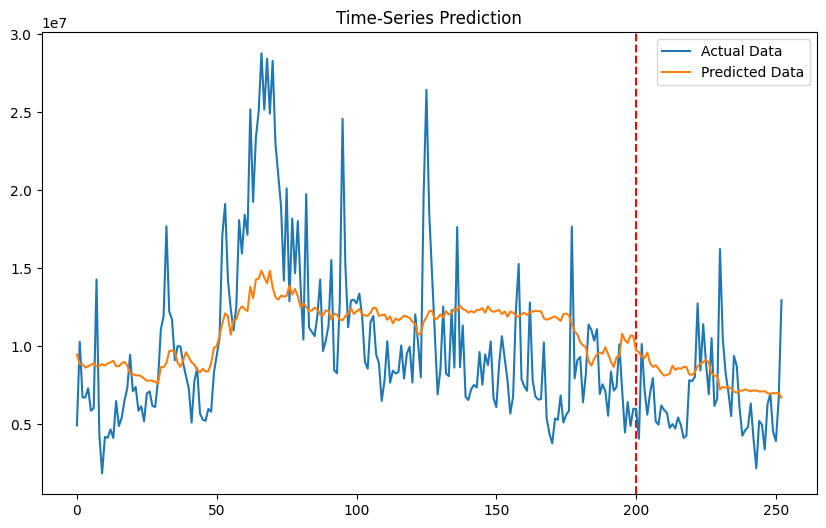

In [4]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c="r", linestyle="--")

plt.plot(label_y, label="Actual Data")
plt.plot(predicted, label="Predicted Data")
plt.title("Time-Series Prediction")
plt.legend()
plt.show()